# Analiza și vizualizarea datelor în domeniul vinurilor

## Preprocesarea datelor

### Încărcarea datelor

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets
from textblob import TextBlob 
from wordcloud import WordCloud

In [2]:
df = pd.read_excel('wine_words.xlsx')
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,title,vintage,alcohol,category
0,Albania,Elegant red fruits and spice on the nose. Vibr...,NaN,91,NaN,Central hilly region,NaN,NaN,Kallmet,Mrizi i Zanave,Gêg Kallmet Superior,2019.0,14.0,Red
1,Albania,Spicy red apple nose with sour cherry and ston...,NaN,86,NaN,Central hilly region,NaN,NaN,Kallmet,Mrizi i Zanave,Roza Kallmet,2020.0,12.5,Rosé
2,Albania,This garnet-colored wine made from 100% Kallme...,NaN,88,20.0,MirditГ«,NaN,NaN,Kallmet,ArbГ«ri,ArbГ«ri 2011 Kallmet (MirditГ«),2011.0,13.9,Red
3,Albania,"Ripe fruity notes, black cherries, prunes, jui...",NaN,87,NaN,Western lowland,NaN,NaN,Kallmet,Mrizi I Zanave,Geg Kallmet Superior,2020.0,14.5,Red
4,Albania,"Rosehip, strawberry jam, some dark berries, an...",NaN,91,NaN,Western lowland,NaN,NaN,Kallmet-Sangiovese-Shesh I Zi,Mrizi I Zanave,Kuven,2020.0,13.5,Red


### Curățarea datelor

Vom elimina caracteristicile de prisos: `vintage` și `designation`.

In [3]:
df = df.drop(['vintage', 'designation', 'region_2'], axis=1)

Vom determina numărul de valori lipsă pe caracteristici.

In [4]:
df.isna().sum()

country             1
description      1275
points              1
price           95713
province         4670
region_1        58991
variety         31160
winery              1
title           23599
alcohol        118499
category        79498
dtype: int64

Eliminăm un tuplu cu valoarea lipsă pentru `country`.

In [5]:
df = df.dropna(subset=['country'])
df.isna().sum()

country             0
description      1274
points              0
price           95712
province         4669
region_1        58990
variety         31159
winery              0
title           23598
alcohol        118499
category        79497
dtype: int64

Valorile nerealistice pentru `alcohol` sunt înlocuite cu valori lipsă.

In [6]:
df.loc[(df['alcohol'] < 5.5) | (df['alcohol'] > 23), 'alcohol'] = np.nan

Valorile marcate cu `-` vor fi valori lipsă.

In [7]:
df = df.replace('-', None)

Valorile lipsă pentru `region_1` vor fi preluate din `province`.

In [8]:
mask = df['region_1'].isna()
df.loc[mask, 'region_1'] = df.loc[mask, 'province']

df = df.drop(['province'], axis=1)
df = df.dropna(subset=['region_1'])

df.isna().sum()

country             0
description      1278
points              3
price           94815
region_1            0
variety         30843
winery              0
title           27999
alcohol        118877
category        79437
dtype: int64

Vor fi eliminate obiectele ce au valori lipsă pentru: `description`, `category`, `variety` și `title`.

In [9]:
df = df.dropna(subset=['description', 'category', 'variety', 'title'])

In [10]:
df.isna().sum()

country            0
description        0
points             2
price          57213
region_1           0
variety            0
winery             0
title              0
alcohol        38892
category           0
dtype: int64

Valorile lipsă vor fi înlocuite în felul următor:
- `points` și `alcohol` - mediile lor aritmetice;
- `price` - prima valoare modală.

In [11]:
df.loc[df['points'].isna(), 'points'] = df['points'].mean()
df.loc[df['price'].isna(), 'price'] = df['price'].mode()[0]
df.loc[df['alcohol'].isna(), 'alcohol'] = df['alcohol'].mean()

In [12]:
df.isna().sum()

country        0
description    0
points         0
price          0
region_1       0
variety        0
winery         0
title          0
alcohol        0
category       0
dtype: int64

Nu există duplicate.

In [13]:
count = df.shape[0]
df.drop_duplicates()
print(df.shape[0] - count)

0


### Transformări

Coloanele sunt convertite în tipurilor lor de date corespunzătoare.

In [14]:
df = df.convert_dtypes()
cols = ['country', 'description', 'region_1', 'variety', 'winery', 'title', 'category']

for col in cols:
    df[col] = df[col].astype('string')

df['points'] = df['points'].astype('int')    
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283449 entries, 0 to 400383
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      283449 non-null  string 
 1   description  283449 non-null  string 
 2   points       283449 non-null  int64  
 3   price        283449 non-null  Float64
 4   region_1     283449 non-null  string 
 5   variety      283449 non-null  string 
 6   winery       283449 non-null  string 
 7   title        283449 non-null  string 
 8   alcohol      283449 non-null  Float64
 9   category     283449 non-null  string 
dtypes: Float64(2), int64(1), string(7)
memory usage: 24.3 MB


Încă o coloană va fi adăugată `price/points`.

In [15]:
df['price/points'] = df['price'] / df['points']

Coloana `region_1` va fi redenumită în `region`.

Coloana `category`, fiind de tip categoric, va fi standardizată.

In [16]:
df = df.rename(columns={'region_1': 'region'})

categories = df['category'].unique()

for category in categories:
    df[category] = df['category'] == category

df = df.drop('category', axis=1)

Rezultatul final:

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283449 entries, 0 to 400383
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   country       283449 non-null  string 
 1   description   283449 non-null  string 
 2   points        283449 non-null  int64  
 3   price         283449 non-null  Float64
 4   region        283449 non-null  string 
 5   variety       283449 non-null  string 
 6   winery        283449 non-null  string 
 7   title         283449 non-null  string 
 8   alcohol       283449 non-null  Float64
 9   price/points  283449 non-null  Float64
 10  Red           283449 non-null  boolean
 11  Rosé          283449 non-null  boolean
 12  White         283449 non-null  boolean
 13  Rose          283449 non-null  boolean
 14  Sparkling     283449 non-null  boolean
 15  Dessert       283449 non-null  boolean
 16  Port/Sherry   283449 non-null  boolean
 17  Fortified     283449 non-null  boolean
 18  Orange   

### Explorare inițială

Statistici descriptive pentru `price`, `points`, `alcohol`.

Vinul cu punctajul minim are 80, dar media este circa 88.

In [18]:
df[['price', 'points', 'alcohol']].describe().map(lambda x: f'{x:.2f}')[1:]

,price,points,alcohol
mean,31.55,88.38,13.56
std,39.55,3.13,1.13
min,4.00,80.00,5.50
25%,18.00,86.00,13.00
50%,20.00,88.00,13.56
75%,35.00,90.00,14.10
max,6000.00,100.00,23.00


Distribuția variabilelor categorice (pentru țară și soi).

In [19]:
df.groupby('region').size()

region
10 Year Old Tawny               6
20 Year Old Tawny               3
25 de Mayo                      3
3 Riberas                       4
Abruzzo                        32
                             ... 
Štajerska Slovenija           125
Г–sterreichischer Perlwein      7
Г–sterreichischer Sekt         79
Е tajerska                     26
ЕЅupa                           7
Length: 2898, dtype: int64

In [20]:
df[categories].sum()

Red            171005
Rosé             2276
White           89035
Rose             7376
Sparkling        8371
Dessert          3683
Port/Sherry      1511
Fortified         131
Orange             61
dtype: Int64

## Analiza textului

### Analiza preliminară

Găsim cele mai frecvente cuvinte din `description`. Au fost alese 100 de rânduri aleatoare pentru a nu consuma prea multe resurse de calcul.

In [21]:
def tokenize(text):
    return WordCloud().generate(text).words_

def get_frequent_words(words):
    return [key for key, value in zip(words.keys(), words.values()) if value >= 0.5]

words = df['description'].sample(100, random_state=0).apply(tokenize)

In [22]:
frequent_words = words.map(get_frequent_words)
frequent_words

22377     [Ripe, red, black, fruits, touches, jam, low, ...
208243    [reasonably, priced, gran, reserva, good, vint...
190382    [nose, rosГ, cheerful, raspberry, strawberry, ...
324821    [Cabernet, red, Meritage, blend, Sauvignon, Me...
168427    [Plummy, dark, berry, aromas, nose, toasty, no...
                                ...                        
321067    [simple, sweet, wine, sugary, cherry, chocolat...
300149    [rich, Chard, made, modern, California, style,...
63741     [wine, 92вЂ, Barrel, Sample, perfumed, smoky, ...
88318     [wine, Sixty, year, old, vines, give, concentr...
379117    [Hogue, built, reputation, stunningly, fruity,...
Name: description, Length: 100, dtype: object

Lungimea medie a descrierii vinurilor:

In [23]:
words.map(len).mean()

np.float64(23.32)

### Wordcloud

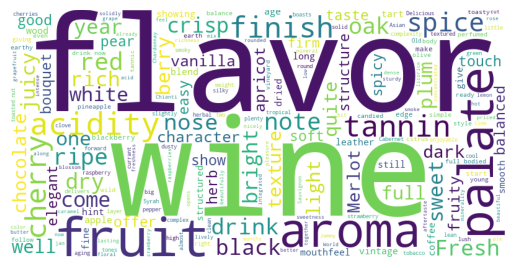

In [24]:
from wordcloud import WordCloud

text = ' '.join(y for x in words.map(dict.keys) for y in x)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.imshow(wordcloud)
plt.axis(False)
plt.show()

## Analiza corelațiilor

Între `price` și `points`.

In [25]:
def formatted_corr(df, annot=False):
    return sns.heatmap(df.corr(), annot=annot)

def formatted_corr_2(df):
    return df.corr().map(lambda x: f'{x * 100:.0f}%')

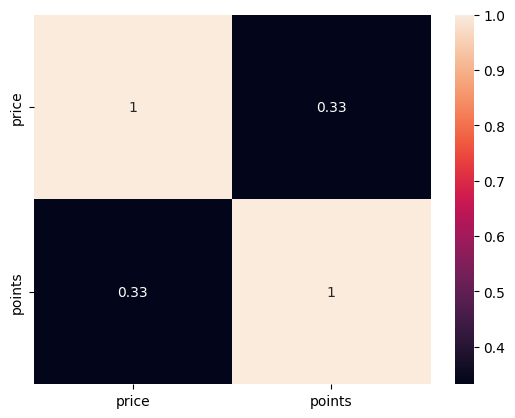

In [26]:
formatted_corr(df[['price', 'points']], True)
plt.show()

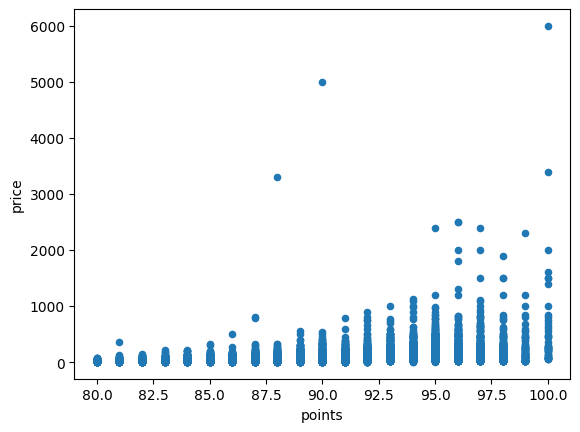

In [27]:
df.plot.scatter(x='points', y='price')
plt.show()

Între `alcohol` și `points`.

Interesant că valoarea de corelație este aproape egală cu valoarea medie pentru alcool.

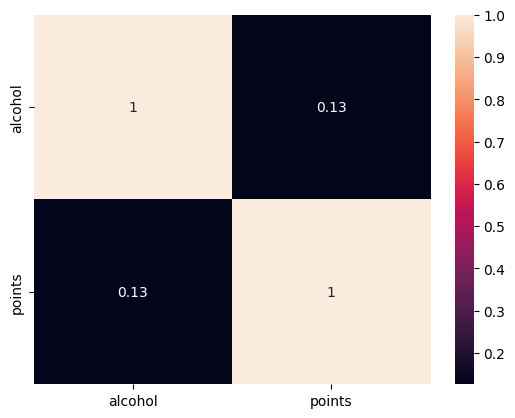

In [28]:
formatted_corr(df[['alcohol', 'points']], True)
plt.show()

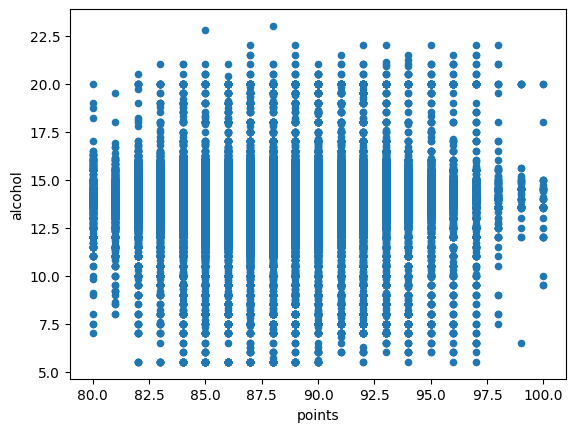

In [29]:
df.plot.scatter(x='points', y='alcohol')
plt.show()

Între `alcohol` și `price/points`.

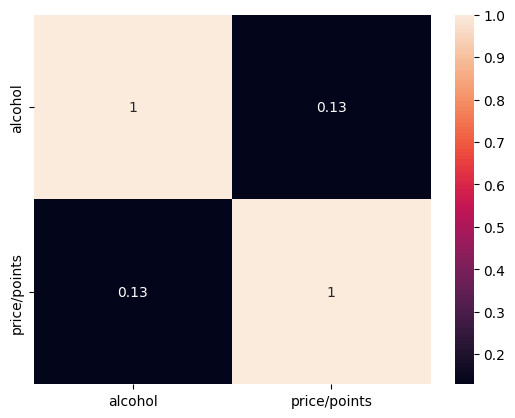

In [30]:
formatted_corr(df[['alcohol', 'price/points']], True)
plt.show()

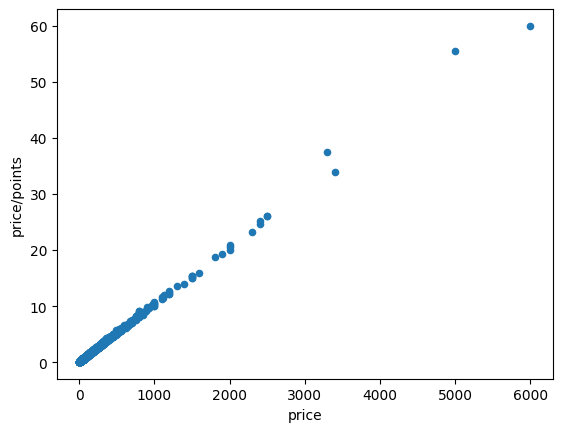

In [31]:
df.plot.scatter(x='price', y='price/points')
plt.show()

Între soiuri și `price/points`.

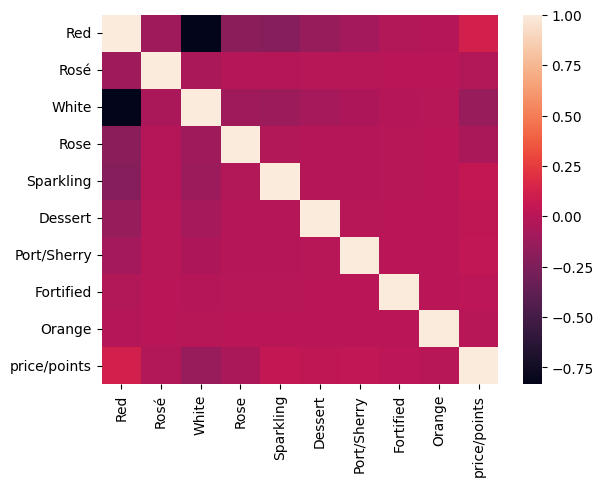

,price/points
Red,12%
Rosé,-3%
White,-13%
Rose,-6%
Sparkling,5%
Dessert,3%
Port/Sherry,4%
Fortified,2%
Orange,-0%


In [32]:
df_temp = df[[*categories, 'price/points']]
formatted_corr(df_temp)
plt.show()

pd.DataFrame(formatted_corr_2(df_temp)['price/points'][:-1])

### Word correlation analysis

Corelare a cuvintelor cele mai frecvente cu `points` și `price`.

Corelațiile importante: 
- `14%`  pentru `tannin` - `points`;
- `10%` pentru `tannin` - `price`;
- `-12%` pentru `flavor` - `points`;
- `-3%` pentru `finish` - `price`.

Există ceva corelație între `palate` și `aroma` (`24%`).

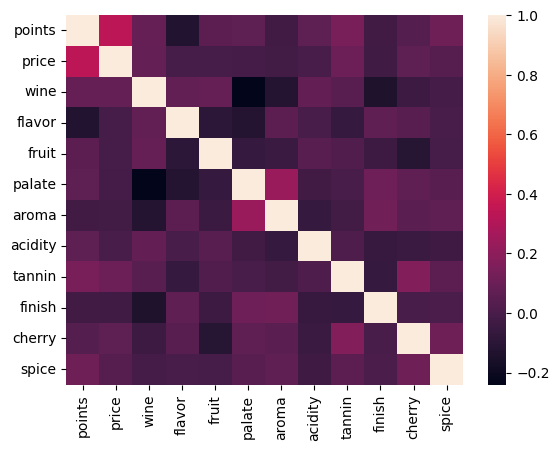

,points,price,wine,flavor,fruit,palate,aroma,acidity,tannin,finish,cherry,spice
points,100%,33%,8%,-12%,6%,6%,-3%,6%,14%,-2%,3%,11%
price,33%,100%,8%,-1%,-1%,-1%,-2%,0%,10%,-3%,6%,4%
wine,8%,8%,100%,7%,9%,-24%,-12%,8%,4%,-14%,-4%,-1%
flavor,-12%,-1%,7%,100%,-9%,-12%,6%,-0%,-6%,7%,5%,0%
fruit,6%,-1%,9%,-9%,100%,-6%,-5%,4%,2%,-4%,-11%,-1%
palate,6%,-1%,-24%,-12%,-6%,100%,24%,-3%,0%,11%,7%,5%
aroma,-3%,-2%,-12%,6%,-5%,24%,100%,-6%,-2%,12%,5%,6%
acidity,6%,0%,8%,-0%,4%,-3%,-6%,100%,1%,-6%,-5%,-4%
tannin,14%,10%,4%,-6%,2%,0%,-2%,1%,100%,-7%,17%,6%
finish,-2%,-3%,-14%,7%,-4%,11%,12%,-6%,-7%,100%,-0%,0%


In [33]:
df_temp = df[['points', 'price']].copy()

for word in [*wordcloud.words_.keys()][:10]:
    df_temp[word] = df['description'].str.contains(word)

formatted_corr(df_temp)
plt.show()

formatted_corr_2(df_temp)

Corelare a cuvintelor cele mai frecvente cu soiuri.

Corelațiile interesante: 
- `43%`  pentru `tannin` - `Red`;
- `35%` pentru `cherry` - `Red`;
- `-37%` pentru `tannin` - `White`.
- `-33%` pentru `cherry` - `White`;
- `-83%` pentru `Red` - `White`.

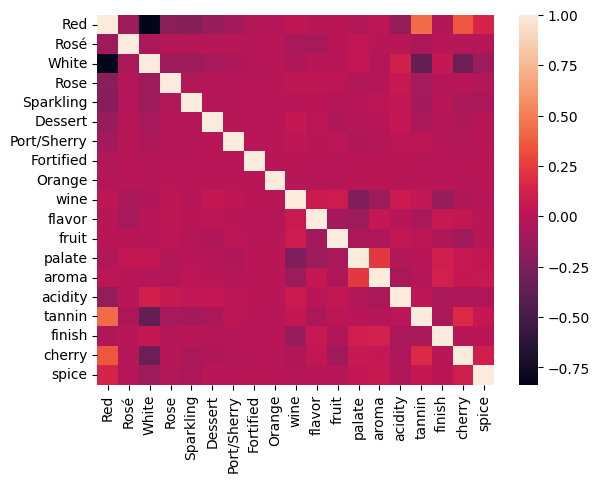

,Red,Rosé,White,Rose,Sparkling,Dessert,Port/Sherry,Fortified,Orange,wine,flavor,fruit,palate,aroma,acidity,tannin,finish,cherry,spice
Red,100%,-11%,-83%,-20%,-22%,-14%,-9%,-3%,-2%,3%,-0%,1%,-3%,2%,-16%,43%,-3%,35%,15%
Rosé,-11%,100%,-6%,-1%,-2%,-1%,-1%,-0%,-0%,-7%,-8%,0%,4%,-0%,-0%,-5%,0%,-2%,-2%
White,-83%,-6%,100%,-11%,-12%,-8%,-5%,-1%,-1%,-4%,0%,0%,4%,-2%,12%,-37%,5%,-33%,-12%
Rose,-20%,-1%,-11%,100%,-3%,-2%,-1%,-0%,-0%,3%,3%,1%,-3%,-1%,6%,-8%,-1%,0%,-3%
Sparkling,-22%,-2%,-12%,-3%,100%,-2%,-1%,-0%,-0%,-0%,1%,-2%,-0%,1%,3%,-9%,-0%,-6%,-5%
Dessert,-14%,-1%,-8%,-2%,-2%,100%,-1%,-0%,-0%,6%,2%,-4%,-2%,-0%,5%,-6%,-2%,-5%,-1%
Port/Sherry,-9%,-1%,-5%,-1%,-1%,-1%,100%,-0%,-0%,3%,0%,1%,-3%,-2%,1%,2%,-1%,-3%,-1%
Fortified,-3%,-0%,-1%,-0%,-0%,-0%,-0%,100%,-0%,1%,0%,-0%,-0%,0%,0%,-1%,0%,-1%,1%
Orange,-2%,-0%,-1%,-0%,-0%,-0%,-0%,-0%,100%,-1%,-1%,-1%,1%,1%,-0%,0%,-0%,-1%,-0%
wine,3%,-7%,-4%,3%,-0%,6%,3%,1%,-1%,100%,7%,9%,-24%,-12%,8%,4%,-14%,-4%,-1%


In [34]:
df_temp = df[categories].copy()

for word in [*wordcloud.words_.keys()][:10]:
    df_temp[word] = df['description'].str.contains(word)

formatted_corr(df_temp)
plt.show()

formatted_corr_2(df_temp)

## Vizualizări avansate

Distribuția punctajelor este aproape normală, unde mediana și moda se apropie de 90.

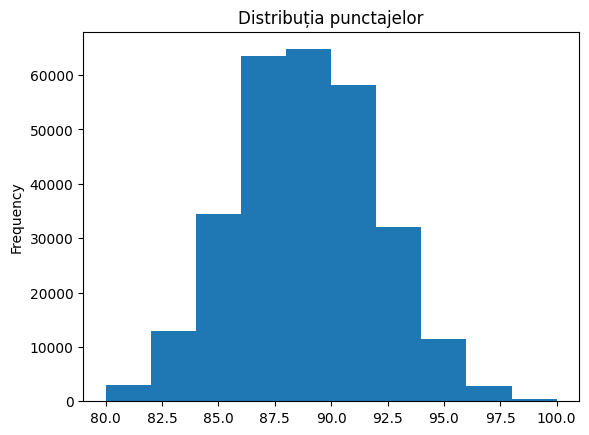

In [35]:
df['points'].plot.hist()
plt.title('Distribuția punctajelor')
plt.show()

Prețurile medii pe țară:

- Cele mai ieftine: `Lithuania` (`10`), `South Korea` (`11`), `Kosovo` (`12.62`);
- Cele mai scumpe: `Germany` (`36.35`), `US-France` (SUA în conjuncție cu Franța?) (`50`), `England` (`50.8`).

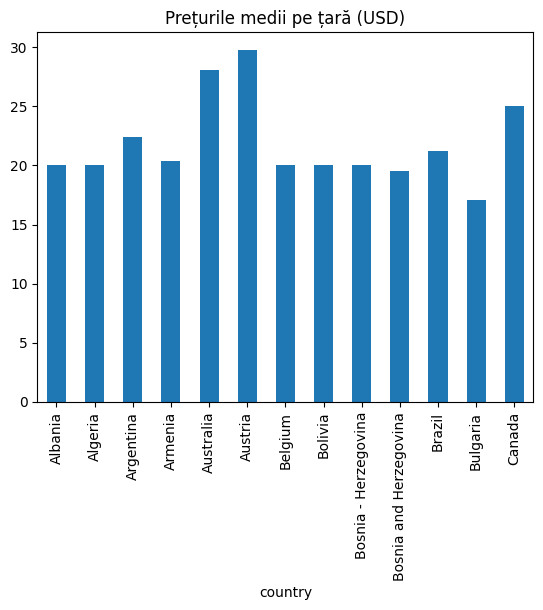

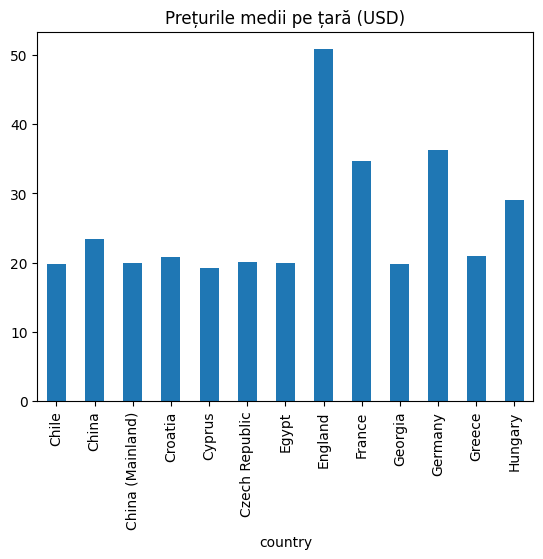

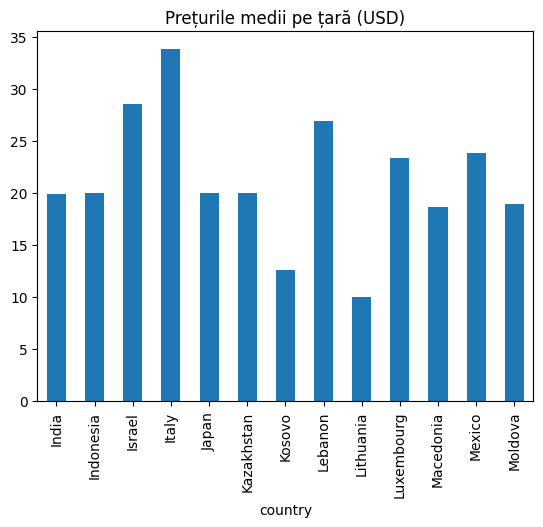

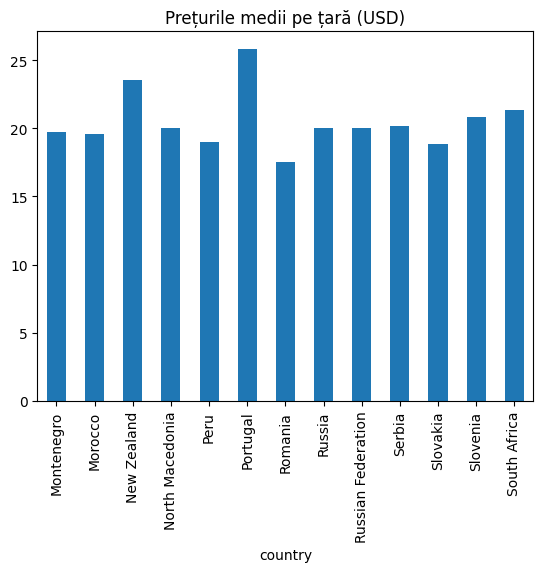

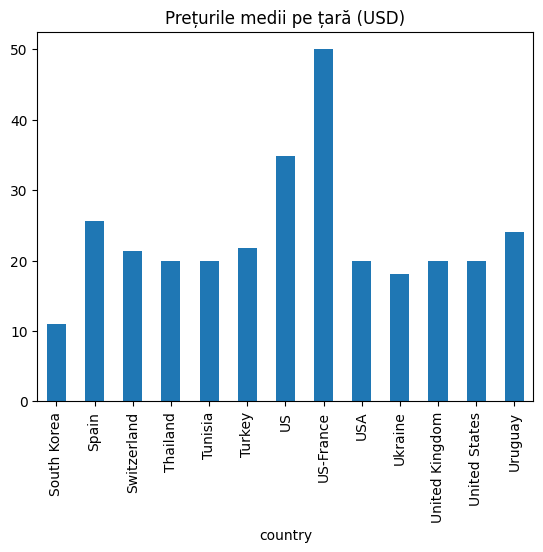

country
Lithuania           10.0
South Korea         11.0
Kosovo         12.615385
Bulgaria       17.103641
Romania        17.557143
                 ...    
France         34.698081
US             34.884926
Germany         36.34704
US-France           50.0
England        50.802469
Name: price, Length: 65, dtype: Float64

In [36]:
temp = df.groupby('country')['price'].mean()

for i in range(int(np.ceil(len(temp) / 13))):
    temp[i * 13:i * 13 + 13].plot(kind='bar')
    plt.title('Prețurile medii pe țară (USD)')
    plt.show()

temp.sort_values()

Distribuția vinurilor după categorii și `country`:

Este observat că vinul de soiul `Red` este cel mai distribuit.

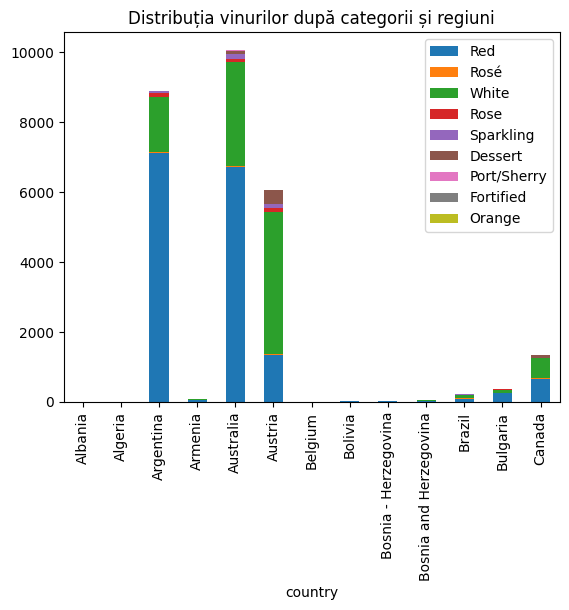

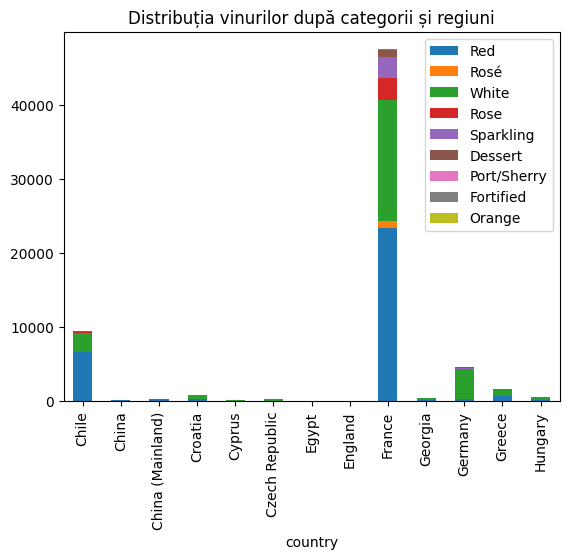

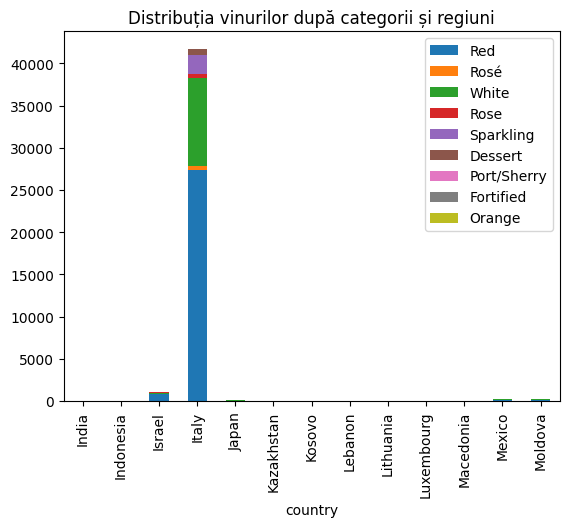

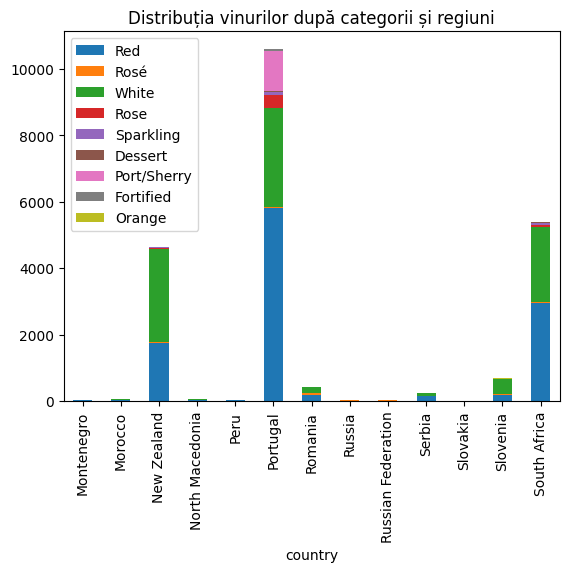

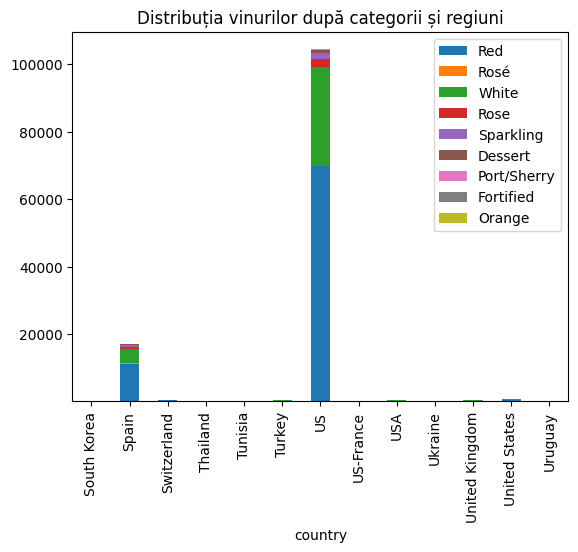

,Red,Rosé,White,Rose,Sparkling,Dessert,Port/Sherry,Fortified,Orange
country,,,,,,,,,
Albania,4,2,1,0,0,0,0,0,0
Algeria,1,0,0,0,0,0,0,0,0
Argentina,7116,20,1579,123,48,9,0,0,0
Armenia,58,1,20,1,0,0,0,0,0
Australia,6725,32,2955,104,147,74,25,7,0
...,...,...,...,...,...,...,...,...,...
USA,216,9,83,0,0,0,0,0,0
Ukraine,23,4,23,1,5,0,0,0,0
United Kingdom,26,91,328,0,0,0,0,0,0


In [37]:
temp = df[['country', *categories]].groupby('country').sum()

for i in range(int(np.ceil(len(temp) / 13))):
    temp[i * 13:i * 13 + 13].plot(kind='bar', stacked=True)
    plt.title('Distribuția vinurilor după categorii și regiuni')
    plt.show()

temp

Scatterplot interactiv ce arată relație dintre `price` și `points`, colorat în funcție de `category`.

# Mini-aplicație

Această mini-aplicație functionează local pe Jupyter Lab sau pe o alternativă ce suportă nucleul Python.

Acest lucru a fost realizat posibil utilizând Jupyter Widgets.

In [38]:
@ipywidgets.interact(categories=ipywidgets.SelectMultiple(options=categories))
def scatter_by_category(categories):
    if len(categories) == 0:
        return
    
    for category in categories:
        filtered = df[df[category]]
        plt.scatter(x=filtered['points'], y=filtered['price'], label=category)

    plt.xlabel('points')
    plt.ylabel('price')
    
    plt.title('Preț vs. punctaj')

    plt.legend()
    plt.show()

interactive(children=(SelectMultiple(description='categories', options=('Red', 'Rosé', 'White', 'Rose', 'Spark…

Căutarea vinurilor după cuvinte cheie:

Rezultatul se exportă într-un fisier extern `query.csv`.

In [39]:
@ipywidgets.interact_manual(country=ipywidgets.Text(),
                            description=ipywidgets.Text(description='keywords'),
                            price=ipywidgets.IntRangeSlider(min=0, max=df['price'].max()),
                            points=ipywidgets.IntRangeSlider(min=0, max=100))
def query(country, description, price, points):
    words = [*map(str.lower, description.split())]
    country = country.strip().lower()

    mask = (price[0] <= df['price']) & (df['price'] >= price[1]) & (points[0] <= df['points']) & (df['price'] >= points[1])

    if len(words) > 0:
        mask &= df['description'].map(lambda x: list(x.lower().split())).map(lambda x: bool(sum(word in x for word in words)))

    if len(country) > 0:
        mask &= df['country'].str.lower() == country

    result = df[mask]

    result.to_csv('query.csv', index=False)
    return result.head()

interactive(children=(Text(value='', continuous_update=False, description='country'), Text(value='', continuou…